# Download and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade "transformers==4.41.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 121.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [1]:
# Standard Libraries
import os
import time
import shutil
import copy
import warnings
from pathlib import Path

# Data Processing and Analysis
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Image Processing
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib import ticker
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Deep Learning Libraries
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import AdamW

# PyTorch Libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms as T  # for simplifying the transforms

# Utility Libraries
import imutils
from IPython.display import clear_output

# Initialize Plotly for Offline Use
init_notebook_mode(connected=True)

# Remove Warnings
warnings.filterwarnings("ignore")

# Random Seed
RANDOM_SEED = 123

# External Libraries Installations
!pip install imutils
# !pip install plotly
clear_output()


In [5]:
import imblearn
print(imblearn.__version__)


0.13.0


In [6]:
# Importing the path to dataset
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/archive")

In [7]:
# Total image count inside the dataset
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

7033


In [8]:
# Iterate over subfolders
for subfolder in data_dir.glob('*'):
    if subfolder.is_dir():  # Check if it's a subfolder
        subfolder_name = subfolder.name
        image_count = 0  # Initialize image count for this subfolder
        # Iterate over class folders within the subfolder
        for class_folder in subfolder.glob('*'):
            if class_folder.is_dir():  # Check if it's a class folder
                # Count images in the class folder
                image_count += len(list(class_folder.glob('*.jpg')))
        print(f"Subfolder: {subfolder_name}, Image Count: {image_count}")


Subfolder: Testing, Image Count: 1311
Subfolder: Training, Image Count: 5722


In [9]:
# Define the image size you want
IMG_SIZE = (384, 384)

NUM_CLASSES = 4

# List of subfolders (classes) in the dataset directory
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Function to load the images and labels from directory

In [10]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [11]:
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/archive/Training/'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/archive/Testing/'

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)

100%|██████████| 4/4 [00:48<00:00, 12.15s/it]


5722 images loaded from /content/drive/MyDrive/Colab Notebooks/archive/Training/ directory.


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

1311 images loaded from /content/drive/MyDrive/Colab Notebooks/archive/Testing/ directory.


In [12]:
# Print the shapes
print("X_Train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_Train Shape: (5722, 384, 384, 3)
y_train Shape: (5722,)
X_test Shape: (1311, 384, 384, 3)
y_test Shape: (1311,)


In [13]:
# Check the data type of the training images
print(f"Data type of MRI images (X_train): {X_train.dtype}")
print(f"Min pixel value: {np.min(X_train)}")
print(f"Max pixel value: {np.max(X_train)}")

Data type of MRI images (X_train): uint8
Min pixel value: 0
Max pixel value: 255


# Visualisation of train-test distribution across different classes

In [14]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_train, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[0],
    name='glioma',
    marker=dict(color='#bada55'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='meningioma',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[2],
    name='notumor',
    marker=dict(color='#00ff33'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='pituitary',
    marker=dict(color='#3300ff'),
    opacity=0.7
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


<h3>Notumour class have more number of samples resulting into a inbalance dataset.</h3>
So, We need to balance the training dataset and keep the testing natural.

In [15]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,2))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

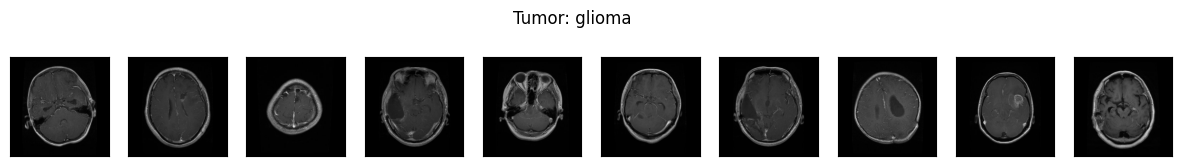

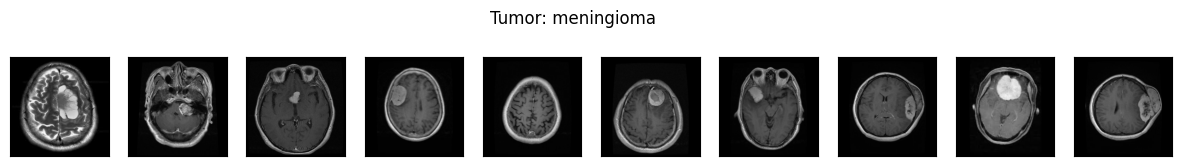

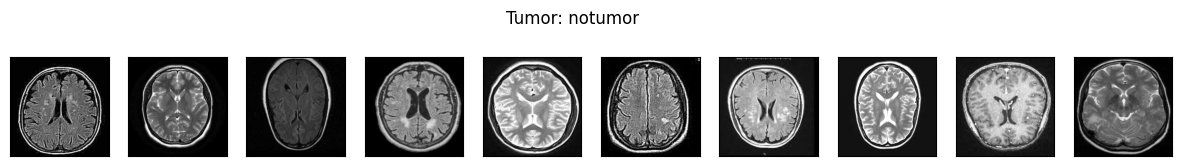

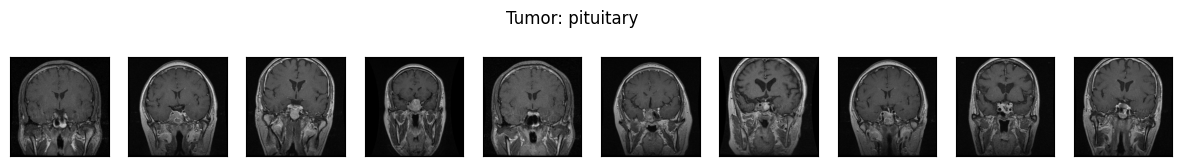

In [16]:
plot_samples(X_train, y_train, labels, 10)

<h3>As we can see, images have different width and height and diffent size of "black corners". Since, we are going to take the image size of (384,384) for the first input layer so some wide images may look weird after resizing.</h3>

**The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.**

In [17]:
def crop_imgs(set_name, add_pixels_value=0, target_shape=(100, 100)):
    """
    Finds the extreme points on the image, crops, and resizes images to a target shape
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped_img = img[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS, extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS]
        resized_img = cv2.resize(cropped_img, target_shape)
        set_new.append(resized_img)

    return np.array(set_new)


# **Let's look at example what this crop function will do with MRI scans:**

In [18]:
# One random sample image path
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/archive/Training/meningioma/Tr-meTr_0006.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

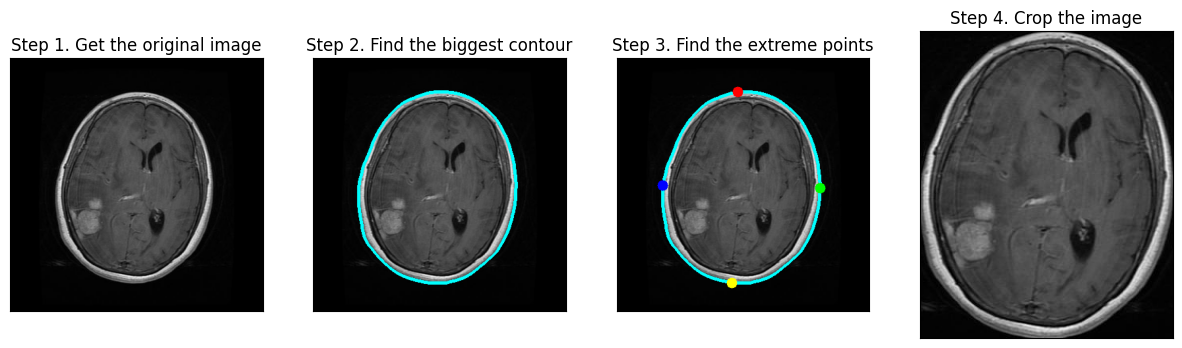

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

# Apply croping to all training images

In [20]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train, target_shape=(384, 384))
X_test_crop = crop_imgs(set_name=X_test, target_shape=(384, 384))

In [21]:
# Print the shapes
print("X_train_crop images Shape:", X_train_crop.shape)

# Check the data type of the X_train_crop images
print(f"Data type of MRI images (X_train_crop): {X_train_crop.dtype}")
print(f"Min pixel value: {np.min(X_train_crop)}")
print(f"Max pixel value: {np.max(X_train_crop)}")

X_train_crop images Shape: (5722, 384, 384, 3)
Data type of MRI images (X_train_crop): uint8
Min pixel value: 0
Max pixel value: 255


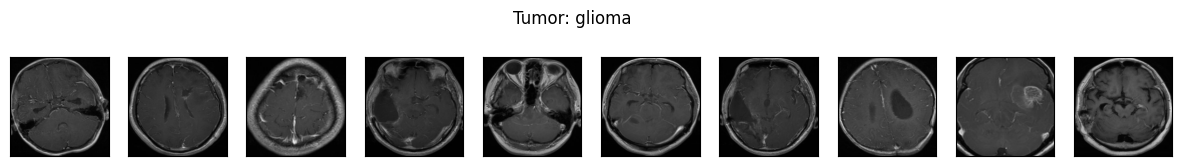

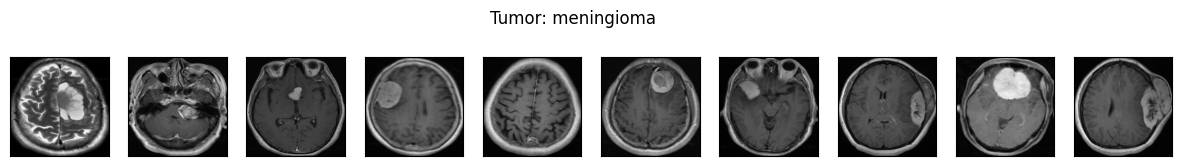

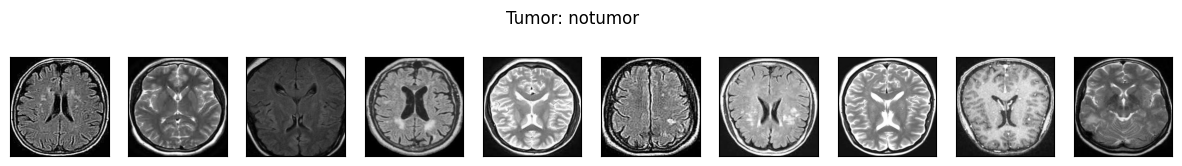

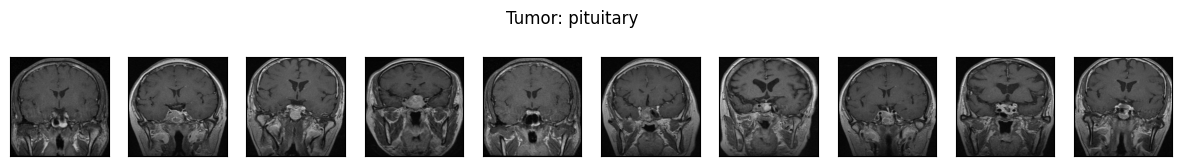

In [22]:
plot_samples(X_train_crop, y_train, labels, 10)

In [23]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for (img, imclass) in zip(x_set, y_set):
        class_name = class_names[imclass]
        cv2.imwrite(f'{folder_name}{class_name}/{class_name}_{i}.png', img)
        i += 1

In [24]:
# Create directories for each class
!mkdir TRAIN_CROP TEST_CROP TRAIN_CROP/glioma TRAIN_CROP/meningioma TRAIN_CROP/notumor TRAIN_CROP/pituitary TEST_CROP/glioma TEST_CROP/meningioma TEST_CROP/notumor TEST_CROP/pituitary
!tree -d

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/glioma’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/meningioma’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/notumor’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/pituitary’: File exists
mkdir: cannot create directory ‘TEST_CROP/glioma’: File exists
mkdir: cannot create directory ‘TEST_CROP/meningioma’: File exists
mkdir: cannot create directory ‘TEST_CROP/notumor’: File exists
mkdir: cannot create directory ‘TEST_CROP/pituitary’: File exists
/bin/bash: line 1: tree: command not found


In [25]:
# Save new images to the folder
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

**2nd Step will be Balancing the training dataset using SMOTE**

In [26]:
Cropped_Img_Dir = "TRAIN_CROP/"

# Initialize empty lists to store images and labels
X = []  # This will store image data
y = []  # This will store corresponding labels

In [27]:
# All subfolders are appended to achieve a more balanced dataset
for subfolder in os.listdir(Cropped_Img_Dir):
    if os.path.isdir(os.path.join(Cropped_Img_Dir, subfolder)):
        label = subfolder
        subfolder_path = os.path.join(Cropped_Img_Dir, subfolder)

        # Iterate through images in the subfolder
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            try:
                # Load the image and append it to X
                image = Image.open(image_path)
                X.append(np.array(image))  # Convert image to numpy array

                # Append the label to y
                y.append(label)
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {str(e)}")

print("Total images loaded:", len(X))
print("Total labels loaded:", len(y))

Total images loaded: 5722
Total labels loaded: 5722


In [28]:
# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

In [29]:
# Reshape each image to a flat 1D array
X_flat = [image.flatten() for image in X]
# Convert the list of flat arrays to a 2D NumPy array
X_flat = np.array(X_flat)

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_flat, y)

# Reshape the flattened images back to their original shape
X_balanced = X_resampled.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

In [30]:
# Assuming you have a list of class labels, e.g., ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = set(y_resampled)  # Assuming 'y_resampled' contains your class labels

# Iterate through each class label and count images
for label in class_labels:
    image_count = sum(1 for item in y_resampled if item == label)
    print(f'Training Folder: {label}, Image Count: {image_count}')

Training Folder: meningioma, Image Count: 1595
Training Folder: notumor, Image Count: 1595
Training Folder: pituitary, Image Count: 1595
Training Folder: glioma, Image Count: 1595


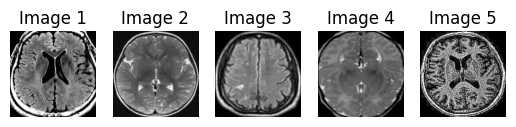

Data type of balanced images (X_balanced): uint8
Min pixel value: 0
Max pixel value: 255


In [31]:
# Assuming X_balanced contains images after balancing
# Plot a few balanced images to check color correctness and data type
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(X_balanced[i])  # Display the image
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.show()

# Check the data type of the balanced images
print(f"Data type of balanced images (X_balanced): {X_balanced.dtype}")
print(f"Min pixel value: {np.min(X_balanced)}")
print(f"Max pixel value: {np.max(X_balanced)}")


In [32]:
def save_img(images, labels, classes, save_dir):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    for idx, (img, label) in enumerate(zip(images, labels)):
        class_dir = save_dir / classes[label]
        class_dir.mkdir(parents=True, exist_ok=True)
        img_path = class_dir / f"image_{idx + 1}.png"
        cv2.imwrite(str(img_path), img)
    print(f"Images saved to {save_dir}")

In [33]:
# Map class names to numeric labels
label_mapping = {class_name: idx for idx, class_name in enumerate(classes)}

# Convert y_resampled to numeric labels using the mapping
y_resampled_numeric = [label_mapping[label] for label in y_resampled]

# Save the Balanced images
save_img(X_balanced, y_resampled_numeric, classes, "/content/Balanced_MRI_Images")

Images saved to /content/Balanced_MRI_Images


In [34]:
# Check the shape of balanced dataset
print("X_balanced Shape:", X_balanced.shape)
print("y_resampled_numeric Shape:", y_resampled.shape)

X_balanced Shape: (6380, 384, 384, 3)
y_resampled_numeric Shape: (6380,)


**A balanced datasets with cropped ROI(reason of intrest) is achieved.**

*Now we will apply augumentation to increse the samples and Before that we explore tha parameters with a demo image.*

# Demo Augmentation

In [35]:
os.makedirs('preview', exist_ok=True)
x = X_balanced[0]
x = x.reshape((1,) + x.shape)

# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [36]:
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='png'):
    i += 1
    if i > 20:
        break

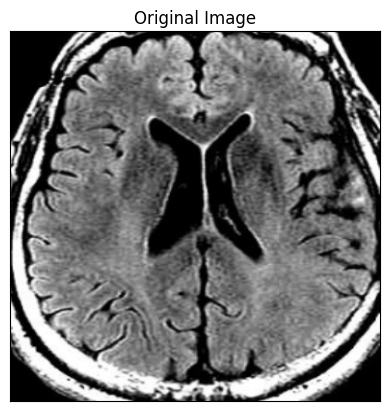

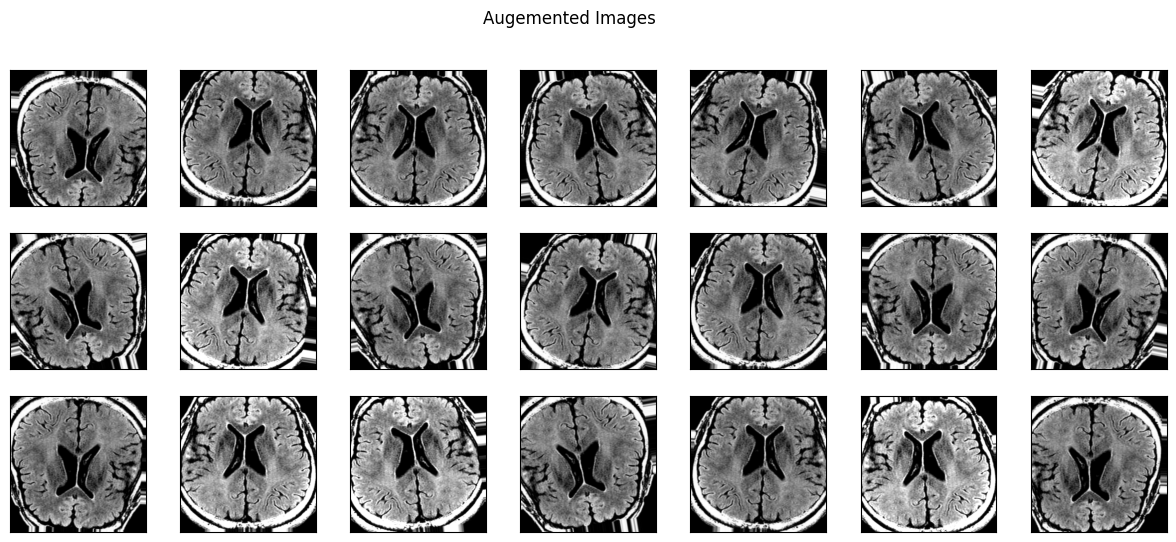

In [37]:
plt.imshow(X_balanced[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [38]:
from collections import Counter

# Assuming 'y_resampled' contains your class labels after SMOTE
print("Unique labels in y_resampled:", np.unique(y_resampled))
print("Class distribution in y_resampled:", Counter(y_resampled))

Unique labels in y_resampled: ['glioma' 'meningioma' 'notumor' 'pituitary']
Class distribution in y_resampled: Counter({np.str_('notumor'): 1595, np.str_('glioma'): 1595, np.str_('pituitary'): 1595, np.str_('meningioma'): 1595})


# Final Augumentation

In [39]:
# Define the class images
glioma_images = X_balanced[y_resampled == 'glioma']
meningioma_images = X_balanced[y_resampled == 'meningioma']
notumor_images = X_balanced[y_resampled == 'notumor']
pituitary_images = X_balanced[y_resampled == 'pituitary']

# Define augmentation factors
glioma_augmentation_factor = 4
meningioma_augmentation_factor = 4
notumor_augmentation_factor = 4
pituitary_augmentation_factor = 4

In [40]:
# Print the shape of the class images
print("Shape of glioma_images", glioma_images.shape)
print("Shape of meningioma_images", meningioma_images.shape)
print("Shape of notumor_images", notumor_images.shape)
print("Shape of pituitary_images", pituitary_images.shape)

Shape of glioma_images (1595, 384, 384, 3)
Shape of meningioma_images (1595, 384, 384, 3)
Shape of notumor_images (1595, 384, 384, 3)
Shape of pituitary_images (1595, 384, 384, 3)


In [41]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,              # Rotate by up to 15 degrees
    width_shift_range=0.15,         # Scale by 15% horizontally
    height_shift_range=0.15,        # Scale by 15% vertically
    horizontal_flip=True,           # Perform horizontal flipping
    vertical_flip=True,             # Perform vertical flipping
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(0, 0.25, x.shape)  # Add Gaussian noise with mean=0 and variance=0.25
)

In [42]:
# Function to apply augmentation, resize, and save images
def aug_images(image_list, label, augmentation_factor, label_name):
    all_images = []
    all_labels = []

    for image in image_list:
        all_images.append(image)
        all_labels.append(label)

    # Generate augmented images on-the-fly
    augmented_data = datagen.flow(np.array(all_images), np.array(all_labels), batch_size=len(all_images), shuffle=False)
    # Get augmented images and labels
    X_augmented, y_augmented = next(augmented_data)
    # Save augmented images
    augmented_path = f"Augmented/Augmented_{label_name}"
    os.makedirs(augmented_path, exist_ok=True)

    for i in range(len(all_images)):
        for j in range(augmentation_factor):
            index = i * augmentation_factor + j
            cv2.imwrite(os.path.join(augmented_path, f'aug_{index+1}.png'), X_augmented[index % len(X_augmented)])

In [43]:
# Process glioma Images
aug_images(glioma_images, 0, glioma_augmentation_factor, 'Glioma')

# Process meningioma Images
aug_images(meningioma_images, 1, meningioma_augmentation_factor, 'Meningioma')

# Process notumor Images
aug_images(notumor_images, 2, notumor_augmentation_factor, 'Notumor')

# Process pituitary Images
aug_images(pituitary_images, 3, pituitary_augmentation_factor, 'Pituitary')

print("Augmentation completed successfully.")

Augmentation completed successfully.


In [44]:
augmented_dir = Path("/content/Augmented")

# Iterate over subfolders and count images in each subfolder
for subfolder in augmented_dir.glob('*'):
    if subfolder.is_dir():  # checks if it's a subfolder
        subfolder_name = subfolder.name
        image_count = len(list(subfolder.glob('*.png')))
        print(f"Folder: {subfolder_name}, Image Count: {image_count}")

Folder: Augmented_Glioma, Image Count: 6380
Folder: Augmented_Pituitary, Image Count: 6380
Folder: Augmented_Notumor, Image Count: 6380
Folder: Augmented_Meningioma, Image Count: 6380


In [45]:
TRAINING_DIR = '/content/Augmented/'

# use predefined function to load the image data into workspace
X_training, y_training, labels = load_data(TRAINING_DIR, IMG_SIZE)

100%|██████████| 4/4 [01:41<00:00, 25.40s/it]


25520 images loaded from /content/Augmented/ directory.


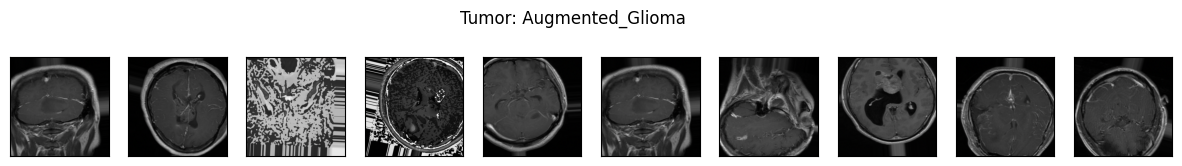

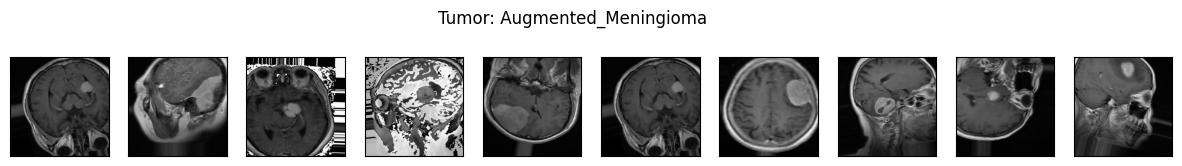

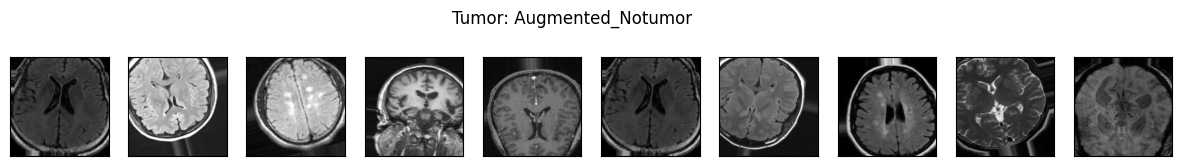

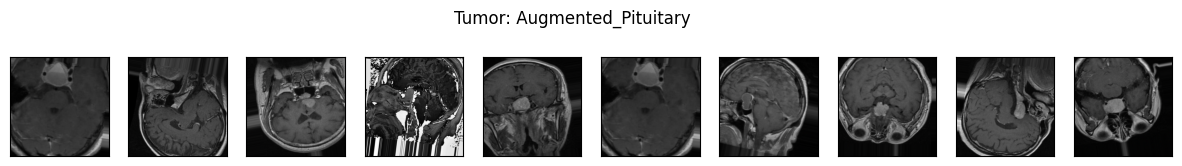

In [46]:
plot_samples(X_training, y_training, labels, 10)

In [47]:
# Check the shapes of the training  sets
print("X_training shape:", X_training.shape)
print("y_training shape:", y_training.shape)

X_training shape: (25520, 384, 384, 3)
y_training shape: (25520,)


In [48]:
# Check the data type of the preprocessed_augmented images
print(f"Data type of HP images (X_training): {X_training.dtype}")
print(f"Min pixel value: {np.min(X_training)}")
print(f"Max pixel value: {np.max(X_training)}")

Data type of HP images (X_training): uint8
Min pixel value: 0
Max pixel value: 255


# Train-Validation split

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the percentages for training and validation sets
TRAIN_PERCENT = 0.7  # 70% for training
VAL_PERCENT = 0.3    # 30% for validation

# Initialize StratifiedShuffleSplit
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=VAL_PERCENT, random_state=42)

# Perform stratified splitting
for train_index, val_index in stratified_splitter.split(X_training, y_training):
    X_Train, y_Train = X_training[train_index], y_training[train_index]
    X_val, y_val = X_training[val_index], y_training[val_index]

# Visualisation of distribution of classes across dataset

In [50]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_Train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='glioma',
    marker=dict(color='#bada55'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='meningioma',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[2],
    name='notumor',
    marker=dict(color='#00ff33'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='pituitary',
    marker=dict(color='#3300ff'),
    opacity=0.7
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


In [51]:
# Check the shapes of the training and validation sets
print("X_Train shape:", X_Train.shape)
print("y_Train shape:", y_Train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_Train shape: (17864, 384, 384, 3)
y_Train shape: (17864,)
X_val shape: (7656, 384, 384, 3)
y_val shape: (7656,)


In [52]:
# Check the data type of the X_Train images
print(f"Data type of HP images (X_Train): {X_Train.dtype}")
print(f"Min pixel value: {np.min(X_Train)}")
print(f"Max pixel value: {np.max(X_Train)}")

Data type of HP images (X_Train): uint8
Min pixel value: 0
Max pixel value: 255


In [53]:
# Create the directories if they don't exist
os.makedirs('Training_Dir', exist_ok=True)
os.makedirs('Validation_Dir', exist_ok=True)

# Use predefined function to load the image data into workspace
# Load resized images as np.arrays to the workspace
def save_images(directory, X, y, img_size=(100, 100)):
    """
    Save resized images as np.arrays to the specified directory
    """
    for i in tqdm(range(len(X))):
        label = labels[y[i]]
        img_name = f"{label}_{i}.png"
        img_path = os.path.join(directory, label, img_name)
        os.makedirs(os.path.dirname(img_path), exist_ok=True)
        img = cv2.resize(X[i], img_size)
        cv2.imwrite(img_path, img)

# Save training images
save_images('Training_Dir', X_Train, y_Train, IMG_SIZE)

# Save validation images
save_images('Validation_Dir', X_val, y_val, IMG_SIZE)

print("Balanced images saved successfully.")

100%|██████████| 7656/7656 [01:07<00:00, 114.00it/s]

Balanced images saved successfully.


# Defining dataloaders

In [54]:
# Define your directories and other constants
TRAINING_DIR = '/content/Training_Dir/'
VALIDATION_DIR = '/content/Validation_Dir/'
TEST_DIR = '/content/TEST_CROP/'

# Define your data transformations and generators
train_transforms = T.Compose([
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
])

test_transforms = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = datasets.ImageFolder(TRAINING_DIR, transform=train_transforms)
validation_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=test_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataloaders = {'train': train_loader, 'val': validation_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(validation_dataset)}


# Proposed Model Architecture

In [55]:
!pip install timm --quiet
import timm

# Load DeIT model
DeIT_model = timm.create_model('deit_base_patch16_384', pretrained=True)

# Unfreeze the last few layers for fine-tuning
num_unfrozen_layers = 32
for param in DeIT_model.parameters():
    param.requires_grad = False

#freezing model
for param in DeIT_model.blocks[-num_unfrozen_layers:].parameters():
    param.requires_grad = True

n_inputs = DeIT_model.head.in_features
DeIT_model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, NUM_CLASSES),
)

print(DeIT_model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=4, bias=True)
)


In [56]:
!pip install torchinfo --quiet
from torchinfo import summary

summary(DeIT_model,input_size=(1,3,384,384))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 4]                    443,904
├─PatchEmbed: 1-1                        [1, 576, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 24, 24]          (590,592)
│    └─Identity: 2-2                     [1, 576, 768]             --
├─Dropout: 1-2                           [1, 577, 768]             --
├─Identity: 1-3                          [1, 577, 768]             --
├─Identity: 1-4                          [1, 577, 768]             --
├─Sequential: 1-5                        [1, 577, 768]             --
│    └─Block: 2-3                        [1, 577, 768]             --
│    │    └─LayerNorm: 3-1               [1, 577, 768]             1,536
│    │    └─Attention: 3-2               [1, 577, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 577, 768]             --
│    │    └─Identity: 3-4                [1, 577, 768]         

In [57]:
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

# Set device and other training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = AdamW(DeIT_model.head.parameters(), lr=0.0001, weight_decay=0.01)
# lr scheduler
reduce_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Function to train the model

In [60]:
# Define your train_model function
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step(running_corrects)  # Pass training accuracy as the metric for ReduceLROnPlateau

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())  # Convert accuracy to numpy array
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().numpy())  # Convert accuracy to numpy array

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/30
----------


100%|██████████| 280/280 [10:28<00:00,  2.25s/it]


train Loss: 0.6063 Acc: 0.8836


100%|██████████| 240/240 [01:29<00:00,  2.67it/s]


val Loss: 0.5567 Acc: 0.9080

Epoch 2/30
----------


100%|██████████| 280/280 [10:27<00:00,  2.24s/it]


train Loss: 0.5618 Acc: 0.9073


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.5215 Acc: 0.9269

Epoch 3/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.5374 Acc: 0.9207


100%|██████████| 240/240 [01:29<00:00,  2.69it/s]


val Loss: 0.5026 Acc: 0.9359

Epoch 4/30
----------


100%|██████████| 280/280 [10:25<00:00,  2.23s/it]


train Loss: 0.5230 Acc: 0.9290


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4850 Acc: 0.9480

Epoch 5/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.5084 Acc: 0.9379


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4730 Acc: 0.9548

Epoch 6/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4936 Acc: 0.9454


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4698 Acc: 0.9544

Epoch 7/30
----------


100%|██████████| 280/280 [10:25<00:00,  2.24s/it]


train Loss: 0.4846 Acc: 0.9495


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4581 Acc: 0.9599

Epoch 8/30
----------


100%|██████████| 280/280 [10:29<00:00,  2.25s/it]


train Loss: 0.4781 Acc: 0.9549


100%|██████████| 240/240 [01:30<00:00,  2.65it/s]


val Loss: 0.4619 Acc: 0.9578

Epoch 9/30
----------


100%|██████████| 280/280 [10:34<00:00,  2.27s/it]


train Loss: 0.4719 Acc: 0.9570


100%|██████████| 240/240 [01:29<00:00,  2.67it/s]


val Loss: 0.4482 Acc: 0.9696

Epoch 10/30
----------


100%|██████████| 280/280 [10:27<00:00,  2.24s/it]


train Loss: 0.4622 Acc: 0.9620


100%|██████████| 240/240 [01:29<00:00,  2.67it/s]


val Loss: 0.4407 Acc: 0.9676

Epoch 11/30
----------


100%|██████████| 280/280 [10:27<00:00,  2.24s/it]


train Loss: 0.4599 Acc: 0.9646


100%|██████████| 240/240 [01:30<00:00,  2.66it/s]


val Loss: 0.4332 Acc: 0.9735

Epoch 12/30
----------


100%|██████████| 280/280 [10:27<00:00,  2.24s/it]


train Loss: 0.4524 Acc: 0.9689


100%|██████████| 240/240 [01:29<00:00,  2.69it/s]


val Loss: 0.4270 Acc: 0.9748

Epoch 13/30
----------


100%|██████████| 280/280 [10:27<00:00,  2.24s/it]


train Loss: 0.4453 Acc: 0.9720


100%|██████████| 240/240 [01:29<00:00,  2.67it/s]


val Loss: 0.4221 Acc: 0.9812

Epoch 14/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4424 Acc: 0.9745


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4194 Acc: 0.9803

Epoch 15/30
----------


100%|██████████| 280/280 [10:31<00:00,  2.25s/it]


train Loss: 0.4412 Acc: 0.9749


100%|██████████| 240/240 [01:29<00:00,  2.69it/s]


val Loss: 0.4164 Acc: 0.9815

Epoch 16/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4349 Acc: 0.9772


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4205 Acc: 0.9790

Epoch 17/30
----------


100%|██████████| 280/280 [10:25<00:00,  2.23s/it]


train Loss: 0.4338 Acc: 0.9785


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4145 Acc: 0.9826

Epoch 18/30
----------


100%|██████████| 280/280 [10:27<00:00,  2.24s/it]


train Loss: 0.4332 Acc: 0.9781


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4240 Acc: 0.9752

Epoch 19/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4277 Acc: 0.9802


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4156 Acc: 0.9820

Epoch 20/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4260 Acc: 0.9824


100%|██████████| 240/240 [01:29<00:00,  2.69it/s]


val Loss: 0.4163 Acc: 0.9809

Epoch 21/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4254 Acc: 0.9822


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4052 Acc: 0.9850

Epoch 22/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4221 Acc: 0.9842


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4056 Acc: 0.9863

Epoch 23/30
----------


100%|██████████| 280/280 [10:25<00:00,  2.24s/it]


train Loss: 0.4215 Acc: 0.9835


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4077 Acc: 0.9837

Epoch 24/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4179 Acc: 0.9856


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4028 Acc: 0.9856

Epoch 25/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4180 Acc: 0.9852


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4218 Acc: 0.9762

Epoch 26/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4162 Acc: 0.9859


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.3949 Acc: 0.9911

Epoch 27/30
----------


100%|██████████| 280/280 [10:25<00:00,  2.23s/it]


train Loss: 0.4148 Acc: 0.9866


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.3957 Acc: 0.9919

Epoch 28/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4120 Acc: 0.9875


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.4015 Acc: 0.9881

Epoch 29/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4114 Acc: 0.9878


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.3989 Acc: 0.9882

Epoch 30/30
----------


100%|██████████| 280/280 [10:26<00:00,  2.24s/it]


train Loss: 0.4101 Acc: 0.9895


100%|██████████| 240/240 [01:29<00:00,  2.68it/s]


val Loss: 0.3987 Acc: 0.9880

Training complete in 358m 24s
Best Val Acc: 0.9919


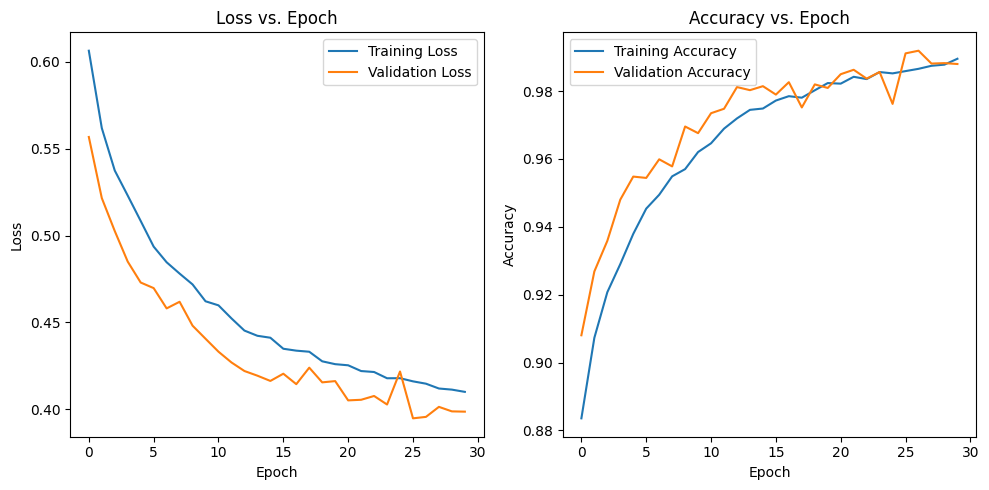

In [61]:
# Now, call your train_model function with the defined parameters including early stopping based on custom criteria
model_ft = train_model(DeIT_model, criterion, optimizer, reduce_lr_scheduler)

# Function to evaluate the model

In [62]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    return cm, report

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       300
           1       0.93      0.94      0.93       306
           2       0.99      0.99      0.99       405
           3       0.98      0.97      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



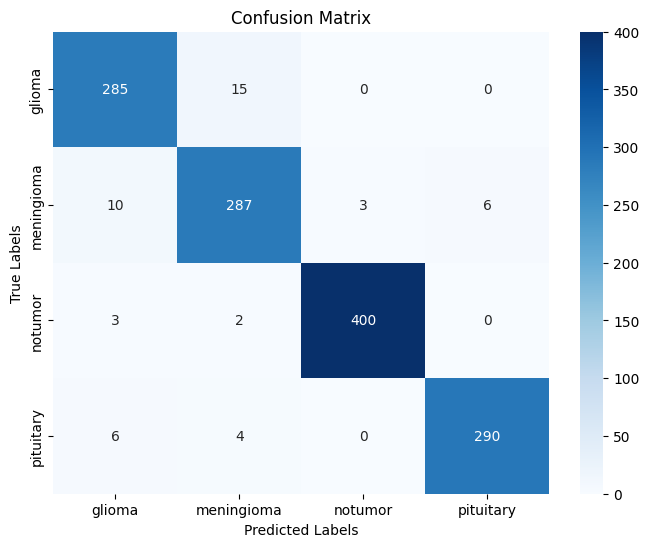

In [63]:
test_cm, test_report = evaluate_model(model_ft, test_loader)
print("Test Classification Report:\n", test_report)
plot_confusion_matrix(test_cm, classes=test_dataset.classes)


In [64]:
import torch

# after training…
torch.save(DeIT_model.state_dict(), "deit_finetuned_state.pth")


In [65]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [67]:
import os, glob, pandas as pd

DATA_ROOT = "/kaggle/input/brain-tumor-classification-mri"
CLASSES   = ["glioma_tumor", "meningioma_tumor",
             "no_tumor",   "pituitary_tumor"]

records = []
for split in ("Training", "Testing"):            # walk both folders
    for cls in CLASSES:
        pattern = os.path.join(DATA_ROOT, split, cls, "*")
        for fp in glob.glob(pattern):
            records.append({"filepath": fp, "class": cls})

df_all = pd.DataFrame(records)                   # 7023 rows total
print(df_all.head())


                                            filepath         class
0  /kaggle/input/brain-tumor-classification-mri/T...  glioma_tumor
1  /kaggle/input/brain-tumor-classification-mri/T...  glioma_tumor
2  /kaggle/input/brain-tumor-classification-mri/T...  glioma_tumor
3  /kaggle/input/brain-tumor-classification-mri/T...  glioma_tumor
4  /kaggle/input/brain-tumor-classification-mri/T...  glioma_tumor


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

ALL_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

all_gen = ALL_datagen.flow_from_dataframe(
    df_all,
    x_col="filepath", y_col="class",
    target_size=(224,224),
    class_mode="categorical",
    shuffle=False,              # keep order for metrics
    batch_size=32
)


Found 3264 validated image filenames belonging to 4 classes.


In [71]:
loss, acc = evaluate_model(model_ft,all_gen)
print(f"Accuracy on combined set: {acc:.4f}")


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [72]:
import shutil, os, pathlib, tqdm

SRC_ROOT = "/kaggle/input/brain-tumor-classification-mri"
DEST_ROOT = "/kaggle/working/all_images"

for cls in CLASSES:
    os.makedirs(os.path.join(DEST_ROOT, cls), exist_ok=True)

# walk both Training/ and Testing/
for img_path in pathlib.Path(SRC_ROOT).rglob("*/*/*.jpg"):
    cls = img_path.parent.name                    # class folder name
    dst = pathlib.Path(DEST_ROOT) / cls / img_path.name
    shutil.copy(img_path, dst)                    # or .symlink_to(img_path)


In [77]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

tfms = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))   # [-1,1]
])

combined_ds = datasets.ImageFolder("/kaggle/working/all_images", transform=tfms)
combined_dl = DataLoader(combined_ds, batch_size=32, shuffle=False, num_workers=4)


# Testing on new dataset https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [80]:
model_ft.eval()
all_preds, all_lbls = [], []
with torch.no_grad():
    for imgs, lbls in combined_dl:
        imgs = imgs.to(device)
        out  = model_ft(imgs)
        all_preds.append(out.argmax(1).cpu())
        all_lbls.append(lbls)

preds = torch.cat(all_preds)
labels = torch.cat(all_lbls)
print(skm.classification_report(labels, preds, target_names=combined_ds.classes))


                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.86      0.83       926
meningioma_tumor       0.89      0.62      0.73       937
        no_tumor       0.78      0.97      0.87       396
 pituitary_tumor       0.86      0.98      0.92       901

        accuracy                           0.84      3160
       macro avg       0.83      0.86      0.84      3160
    weighted avg       0.84      0.84      0.83      3160



In [79]:
# OPTION 1 – keep the 'skm' alias exactly as in my snippet
import sklearn.metrics as skm

# OPTION 2 – import only the function you need, then drop the skm. prefix later
# from sklearn.metrics import classification_report


In [81]:
pip install -q grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [130]:
import cv2, torch
from torchvision import transforms
from pathlib import Path

# --- original 384×384 transform (identical to evaluation) -------------
tfms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))   # whatever you used
])

img_path = Path("/content/TEST_CROP/pituitary/pituitary_1013.png")  # example
rgb      = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB) / 255.0
tensor   = tfms(Image.fromarray((rgb*255).astype("uint8")))

input_tensor = tensor.unsqueeze(0).to(device)            # [1,3,384,384]


In [131]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- pick a layer -----------------------------
# For ViT/DeiT the usual choice is the *norm* layer right before the last block
target_layers = [model_ft.blocks[-1].norm1]

# --- build CAM engine -------------------------
cam = GradCAM(model=model_ft,
              target_layers=target_layers,
             )


In [132]:
import math, torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ------------------------------------------------------------------
# 1)  reshape_transform for ViT / DeiT
# ------------------------------------------------------------------
def vit_reshape_transform(tensor):
    """
    * tensor shape: [B, Tokens, Embedding]  (CLS + N_patches tokens)
    * returns     : [B, Embedding, H, W]    so CAM sees a 4-D map
    """
    # Drop CLS token
    tensor = tensor[:, 1:, :]                       # [B, N, C]
    b, n, c = tensor.shape
    h = w = int(math.sqrt(n))                       # 24 for 384×384 with 16-px patches
    tensor = tensor.reshape(b, h, w, c)
    tensor = tensor.permute(0, 3, 1, 2)             # [B, C, H, W]
    return tensor

# ------------------------------------------------------------------
# 2)  Build the CAM object with that transformer
# ------------------------------------------------------------------
target_layers = [model_ft.blocks[-1].norm1]         # same as before

cam = GradCAM(model=model_ft,
              target_layers=target_layers,
              reshape_transform=vit_reshape_transform)

# ------------------------------------------------------------------
# 3)  Forward pass & CAM generation
# ------------------------------------------------------------------
model_ft.eval()
with torch.no_grad():
    logits = model_ft(input_tensor)
    pred_idx = int(logits.argmax(1))

targets       = [ClassifierOutputTarget(pred_idx)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]   # OK now

heatmap = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
cv2.imwrite("gradcam_vit11.jpg", cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
print("✓ gradcam_vit.jpg saved")


✓ gradcam_vit.jpg saved
